#### Import Libraries

In [2]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import sep
from time import time
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F, SparkSession, Column,types
from pyspark.sql.functions import col,isnan,when,count, split, to_timestamp
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.fpm import FPGrowth,FPGrowthModel
from pyspark.ml.feature import OneHotEncoder, StringIndexer, CountVectorizer
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import lit
%matplotlib inline

#### Create Spark Session

In [3]:
spark = SparkSession.builder.appName('SalesMarketBasketAnalysis').getOrCreate()
sqlCtx = SQLContext(spark)
spark

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


#### Load the dataset

In [4]:
df = spark.read.csv('Sales_Data.csv',header=True,sep=";",inferSchema=True)

In [5]:
df.show(5)

+------+--------------------+--------+----------------+-----+----------+--------------+
|BillNo|            Itemname|Quantity|            Date|Price|CustomerID|       Country|
+------+--------------------+--------+----------------+-----+----------+--------------+
|536365|WHITE HANGING HEA...|       6|01.12.2010 08:26| 2,55|     17850|United Kingdom|
|536365| WHITE METAL LANTERN|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|CREAM CUPID HEART...|       8|01.12.2010 08:26| 2,75|     17850|United Kingdom|
|536365|KNITTED UNION FLA...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|RED WOOLLY HOTTIE...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
+------+--------------------+--------+----------------+-----+----------+--------------+
only showing top 5 rows



## Dataset exploration & Preprocessing

In [6]:
type(df)

pyspark.sql.dataframe.DataFrame

In [7]:
df.show(5)

+------+--------------------+--------+----------------+-----+----------+--------------+
|BillNo|            Itemname|Quantity|            Date|Price|CustomerID|       Country|
+------+--------------------+--------+----------------+-----+----------+--------------+
|536365|WHITE HANGING HEA...|       6|01.12.2010 08:26| 2,55|     17850|United Kingdom|
|536365| WHITE METAL LANTERN|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|CREAM CUPID HEART...|       8|01.12.2010 08:26| 2,75|     17850|United Kingdom|
|536365|KNITTED UNION FLA...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
|536365|RED WOOLLY HOTTIE...|       6|01.12.2010 08:26| 3,39|     17850|United Kingdom|
+------+--------------------+--------+----------------+-----+----------+--------------+
only showing top 5 rows



In [8]:
df.count()

522064

In [9]:
df.printSchema()

root
 |-- BillNo: string (nullable = true)
 |-- Itemname: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [10]:
df.columns

['BillNo', 'Itemname', 'Quantity', 'Date', 'Price', 'CustomerID', 'Country']

In [11]:
df.select('CustomerID').distinct().count()

4298

In [12]:
df.dtypes

[('BillNo', 'string'),
 ('Itemname', 'string'),
 ('Quantity', 'int'),
 ('Date', 'string'),
 ('Price', 'string'),
 ('CustomerID', 'int'),
 ('Country', 'string')]

#### Changing column type

In [13]:
df = df.withColumn("Price",F.regexp_replace("Price",",","."))
df = df.withColumn("Price",F.col("Price").cast("float"))

In [14]:
df = df.withColumn("Quantity",F.col("Quantity").cast("int"))

In [15]:
df.printSchema()

root
 |-- BillNo: string (nullable = true)
 |-- Itemname: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



#### Check null values

In [16]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+--------+--------+----+-----+----------+-------+
|BillNo|Itemname|Quantity|Date|Price|CustomerID|Country|
+------+--------+--------+----+-----+----------+-------+
|     0|    1455|       0|   0|    0|    134041|      0|
+------+--------+--------+----+-----+----------+-------+



#### Droping the values less than 0 or equal to 0

In [17]:
df = df.filter((F.col("Price")>0) & (F.col("Quantity")>0))

#### Creating new column for 'Total Price'

In [18]:
df = df.withColumn("TotalPrice",F.round(F.col("Price")*F.col("Quantity"),2))

In [19]:
df.show(5)

+------+--------------------+--------+----------------+-----+----------+--------------+----------+
|BillNo|            Itemname|Quantity|            Date|Price|CustomerID|       Country|TotalPrice|
+------+--------------------+--------+----------------+-----+----------+--------------+----------+
|536365|WHITE HANGING HEA...|       6|01.12.2010 08:26| 2.55|     17850|United Kingdom|      15.3|
|536365| WHITE METAL LANTERN|       6|01.12.2010 08:26| 3.39|     17850|United Kingdom|     20.34|
|536365|CREAM CUPID HEART...|       8|01.12.2010 08:26| 2.75|     17850|United Kingdom|      22.0|
|536365|KNITTED UNION FLA...|       6|01.12.2010 08:26| 3.39|     17850|United Kingdom|     20.34|
|536365|RED WOOLLY HOTTIE...|       6|01.12.2010 08:26| 3.39|     17850|United Kingdom|     20.34|
+------+--------------------+--------+----------------+-----+----------+--------------+----------+
only showing top 5 rows



#### Imputing values

In [20]:
df = df.na.fill(value=99999,subset=["CustomerID"])

In [21]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+--------+--------+----+-----+----------+-------+----------+
|BillNo|Itemname|Quantity|Date|Price|CustomerID|Country|TotalPrice|
+------+--------+--------+----+-----+----------+-------+----------+
|     0|       0|       0|   0|    0|         0|      0|         0|
+------+--------+--------+----+-----+----------+-------+----------+



#### Removing Non-Items

In [22]:
df = df.filter((F.col("Itemname")!='POSTAGE') & (F.col("Itemname")!='DOTCOM POSTAGE') & (F.col("Itemname")!='Adjust bad debt') & (F.col("Itemname")!='Manual'))

#### Changing Column Type (Date)

In [23]:
df = df.withColumn("Time",F.split("Date"," ",0)[1])

In [24]:
df = df.withColumn("Date",F.split("Date"," ",0)[0])
df = df.withColumn("Date", to_date(df["Date"], "dd.MM.yyyy"))

#### Rearranging columns

In [25]:
df = df.select('BillNo', 'Itemname', 'Quantity', 'Price', 'CustomerID', 'Country','Date', 'Time','TotalPrice')
df.show(5)

+------+--------------------+--------+-----+----------+--------------+----------+-----+----------+
|BillNo|            Itemname|Quantity|Price|CustomerID|       Country|      Date| Time|TotalPrice|
+------+--------------------+--------+-----+----------+--------------+----------+-----+----------+
|536365|WHITE HANGING HEA...|       6| 2.55|     17850|United Kingdom|2010-12-01|08:26|      15.3|
|536365| WHITE METAL LANTERN|       6| 3.39|     17850|United Kingdom|2010-12-01|08:26|     20.34|
|536365|CREAM CUPID HEART...|       8| 2.75|     17850|United Kingdom|2010-12-01|08:26|      22.0|
|536365|KNITTED UNION FLA...|       6| 3.39|     17850|United Kingdom|2010-12-01|08:26|     20.34|
|536365|RED WOOLLY HOTTIE...|       6| 3.39|     17850|United Kingdom|2010-12-01|08:26|     20.34|
+------+--------------------+--------+-----+----------+--------------+----------+-----+----------+
only showing top 5 rows



## EDA

In [26]:
df.createOrReplaceTempView("df")

In [27]:
total_price_by_country = sqlCtx.sql("""SELECT Country, ROUND(SUM(TotalPrice), 2) AS Price FROM df GROUP BY Country""")
total_price_by_country.orderBy('Price', ascending=False).show(10)

+--------------+----------+
|       Country|     Price|
+--------------+----------+
|United Kingdom|8763711.59|
|   Netherlands| 283889.34|
|       Germany| 205569.89|
|        France| 184768.74|
|     Australia| 138171.31|
|         Spain|  55725.11|
|   Switzerland|   53087.9|
|         Japan|  37416.37|
|       Belgium|  36927.34|
|        Sweden|  36839.33|
+--------------+----------+
only showing top 10 rows



In [28]:
top_product_country = sqlCtx.sql("""SELECT Country, Itemname, Quantity FROM
    (SELECT Country, Itemname, Quantity, MAX(Quantity) OVER(PARTITION BY Country) AS Max_Quant FROM df)
    WHERE Quantity=MAX_QUANT
    """)
top_product_country.orderBy('Quantity', ascending=False).show(20, truncate=False)

+--------------+-----------------------------------+--------+
|Country       |Itemname                           |Quantity|
+--------------+-----------------------------------+--------+
|United Kingdom|PAPER CRAFT , LITTLE BIRDIE        |80995   |
|Netherlands   |RABBIT NIGHT LIGHT                 |2400    |
|Japan         |RABBIT NIGHT LIGHT                 |2040    |
|Australia     |MINI PAINT SET VINTAGE             |1152    |
|France        |RABBIT NIGHT LIGHT                 |912     |
|Sweden        |12 PENCILS SMALL TUBE RED RETROSPOT|768     |
|Germany       |ASSORTED COLOURS SILK FAN          |600     |
|Spain         |PINK 3 PIECE POLKADOT CUTLERY SET  |360     |
|Spain         |BLUE 3 PIECE POLKADOT CUTLERY SET  |360     |
|Spain         |CHILDRENS CUTLERY POLKADOT PINK    |360     |
|Spain         |CHILDRENS CUTLERY POLKADOT BLUE    |360     |
|Spain         |CHILDRENS CUTLERY POLKADOT PINK    |360     |
|Austria       |SET 12 KIDS COLOUR  CHALK STICKS   |288     |
|Switzer

In [29]:
expense_per_customer = sqlCtx.sql("""SELECT CustomerID, Country, SUM(TotalPrice) as Price FROM df WHERE CustomerID <> 99999 GROUP BY CustomerID, Country""")
expense_per_customer.orderBy('Price', ascending=False).show(10)

+----------+--------------+------------------+
|CustomerID|       Country|             Price|
+----------+--------------+------------------+
|     14646|   Netherlands| 279138.0201046169|
|     18102|United Kingdom|259657.30027222633|
|     17450|United Kingdom|194550.79052352905|
|     16446|United Kingdom|168472.49374997616|
|     12415|     Australia|124564.53000074625|
|     17511|United Kingdom| 91062.38004624844|
|     12346|United Kingdom|       77183.59375|
|     16029|United Kingdom| 72882.09001159668|
|     16684|United Kingdom| 66653.56011009216|
|     13694|United Kingdom| 65039.61996245384|
+----------+--------------+------------------+
only showing top 10 rows



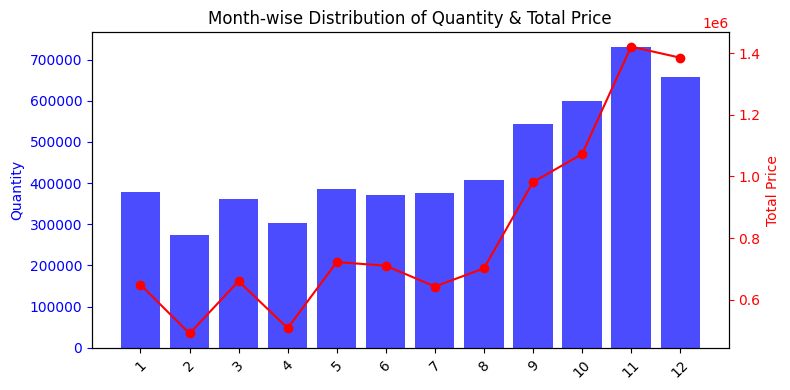

In [30]:
monthly_data = df.groupBy(F.month("Date").alias("Month")) \
    .agg(F.sum("Quantity").alias("TotalQuantity"), F.sum("TotalPrice").alias("TotalPrice")) \
    .orderBy("Month")

pandas_df = monthly_data.toPandas()

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.bar(pandas_df.index, pandas_df['TotalQuantity'], color='b', alpha=0.7, label='Quantity')
ax1.set_ylabel('Quantity', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(pandas_df.index, pandas_df['TotalPrice'], color='r', marker='o', label='Total Price')
ax2.set_ylabel('Total Price', color='r')
ax2.tick_params('y', colors='r')

ax1.set_xticks(pandas_df.index)
ax1.set_xticklabels([month for month in pandas_df['Month']], rotation=45)

plt.title('Month-wise Distribution of Quantity & Total Price')
fig.tight_layout()

plt.show()

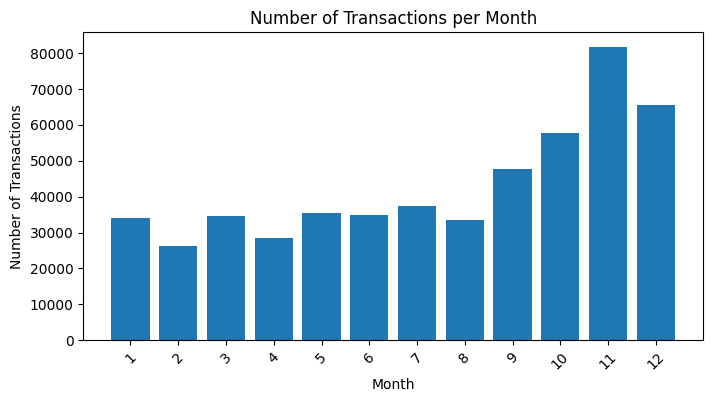

In [31]:
# No_Of_Trans per month
transactions_per_month = df.groupBy(F.month("Date").alias("Month")) \
    .agg(F.count("BillNo").alias("No_Of_Trans"))

transactions_per_month_pd = transactions_per_month.toPandas()
plt.figure(figsize=(8, 4))
plt.bar(transactions_per_month_pd["Month"], transactions_per_month_pd["No_Of_Trans"])
plt.title("Number of Transactions per Month")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.xticks(transactions_per_month_pd["Month"], transactions_per_month_pd["Month"], rotation=45)
plt.show()

In [32]:
df = df.withColumn("Month", F.month("Date"))

unit_per_transaction = df.groupBy("Month").agg((F.sum("Quantity") / F.countDistinct("BillNo")).alias("Unit_Per_Transaction"))
avg_transaction_value = df.groupBy("Month").agg((F.sum("TotalPrice") / F.countDistinct("BillNo")).alias("Avg_Transaction_Value"))
avg_selling_price = df.groupBy("Month").agg((F.sum("TotalPrice") / F.sum("Quantity")).alias("Avg_Selling_Price"))
no_of_trans = df.groupBy("Month").agg(F.countDistinct("BillNo").alias("No_Of_Trans"))

unit_per_transaction_pd = unit_per_transaction.toPandas()
avg_transaction_value_pd = avg_transaction_value.toPandas()
avg_selling_price_pd = avg_selling_price.toPandas()
no_of_trans_pd = no_of_trans.toPandas()

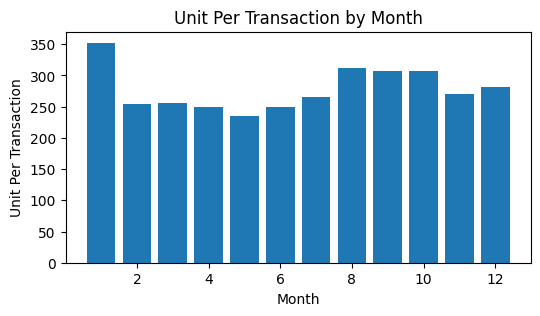

In [33]:
# Unit Per Transaction by month
plt.figure(figsize=(6, 3))
plt.bar(unit_per_transaction_pd["Month"], unit_per_transaction_pd["Unit_Per_Transaction"])
plt.xlabel("Month")
plt.ylabel("Unit Per Transaction")
plt.title("Unit Per Transaction by Month")
plt.show()

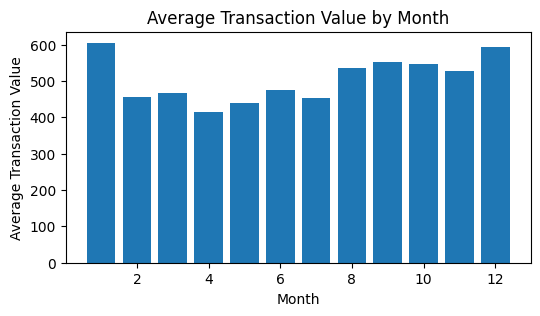

In [34]:
# Average Transaction Value by month
plt.figure(figsize=(6, 3))
plt.bar(avg_transaction_value_pd["Month"], avg_transaction_value_pd["Avg_Transaction_Value"])
plt.xlabel("Month")
plt.ylabel("Average Transaction Value")
plt.title("Average Transaction Value by Month")
plt.show()

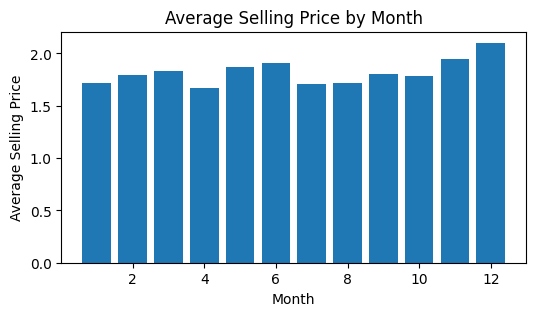

In [35]:
# Average Selling Price by month
plt.figure(figsize=(6, 3))
plt.bar(avg_selling_price_pd["Month"], avg_selling_price_pd["Avg_Selling_Price"])
plt.xlabel("Month")
plt.ylabel("Average Selling Price")
plt.title("Average Selling Price by Month")
plt.show()

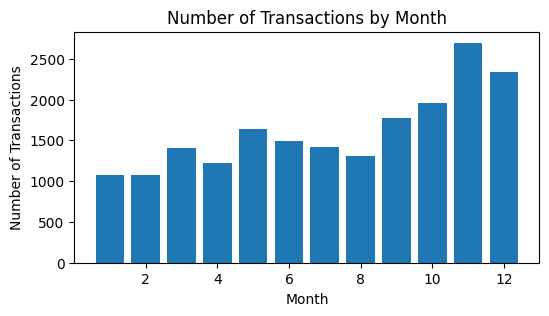

In [36]:
# No_Of_Trans by month
plt.figure(figsize=(6, 3))
plt.bar(no_of_trans_pd["Month"], no_of_trans_pd["No_Of_Trans"])
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.title("Number of Transactions by Month")
plt.show()

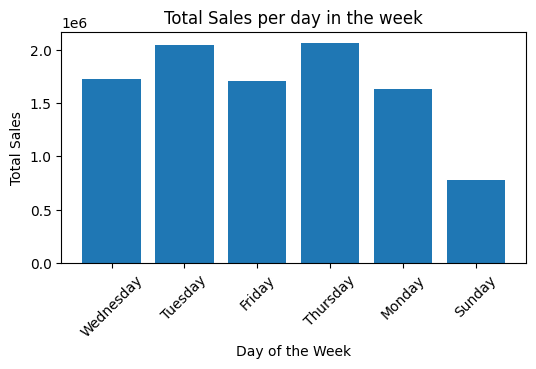

In [37]:
df = df.withColumn("DayOfWeek", F.date_format("Date", "EEEE"))
total_sales_per_day = df.groupBy("DayOfWeek").agg(F.sum("TotalPrice").alias("TotalSales"))
total_sales_per_day_pd = total_sales_per_day.toPandas()

# Total Sales per day in the week
plt.figure(figsize=(6, 3))
plt.bar(total_sales_per_day_pd["DayOfWeek"], total_sales_per_day_pd["TotalSales"])
plt.xlabel("Day of the Week")
plt.ylabel("Total Sales")
plt.title("Total Sales per day in the week")
plt.xticks(rotation=45)
plt.show()

## Association Rule

In [38]:
indexer = StringIndexer(inputCol="Itemname", outputCol="ItemnameIndex")

df_group = indexer.fit(df).transform(df)

df_group = df_group[['Country', 'BillNo', 'Itemname']].distinct()

df_group = df_group.groupBy('BillNo', 'Country').agg(collect_list('Itemname').alias('Itemname_vec'))

df_group.show()

+------+--------------+--------------------+
|BillNo|       Country|        Itemname_vec|
+------+--------------+--------------------+
|536365|United Kingdom|[GLASS STAR FROST...|
|536368|United Kingdom|[RED COAT RACK PA...|
|536369|United Kingdom|[BATH BUILDING BL...|
|536371|United Kingdom|[PAPER CHAIN KIT ...|
|536372|United Kingdom|[HAND WARMER UNIO...|
|536373|United Kingdom|[KNITTED UNION FL...|
|536375|United Kingdom|[EDWARDIAN PARASO...|
|536380|United Kingdom|[JAM MAKING SET P...|
|536381|United Kingdom|[CERAMIC CHERRY C...|
|536387|United Kingdom|[RED TOADSTOOL LE...|
|536388|United Kingdom|[HEART OF WICKER ...|
|536393|United Kingdom|    [RETROSPOT LAMP]|
|536394|United Kingdom|[FANCY FONT BIRTH...|
|536395|United Kingdom|[BLACK HEART CARD...|
|536398|United Kingdom|[CHOCOLATE HOT WA...|
|536402|United Kingdom|[HOT WATER BOTTLE...|
|536404|United Kingdom|[PACK OF 72 RETRO...|
|536405|United Kingdom|[SET/5 RED RETROS...|
|536407|United Kingdom|[HAND WARMER UNIO...|
|536409|Un

In [39]:
countries = []
for country in df[['Country']].distinct().collect():
    countries.append(country['Country'])

In [40]:
minSupport=0.1
minConfidence=0.8
results = {}

countries = ['Belgium', 'Germany', 'Italy', 'Netherlands', 'Portugal', 'Norway', 'Spain', 'Sweden', 'Australia' ]

for country in countries:
    fpGrowth = FPGrowth(itemsCol="Itemname_vec", minSupport=minSupport, minConfidence=minConfidence)
    model = fpGrowth.fit(df_group.filter(df_group['Country']==country))
    results[country] = model.associationRules

In [41]:
country = countries[0]
apriori = results[country].withColumn('country', lit(country))

for country in countries[1:5]:
    df_temp = results[country].withColumn('country', lit(country))
    apriori =  apriori.union(df_temp)

In [42]:
apriori.createOrReplaceTempView("apriori")
rules = sqlCtx.sql("""SELECT antecedent, consequent, COUNT(DISTINCT country) as n_country , ROUND(AVG(lift), 3) as mean_lift, ROUND(MIN(lift), 3) as min_lift FROM apriori GROUP BY antecedent, consequent""")
rules.sort(col('n_country').desc(), col('mean_lift').desc()).show(10, truncate=False)

+----------------------------------------------------------------+-------------------------------------+---------+---------+--------+
|antecedent                                                      |consequent                           |n_country|mean_lift|min_lift|
+----------------------------------------------------------------+-------------------------------------+---------+---------+--------+
|[ROUND SNACK BOXES SET OF 4 FRUITS]                             |[ROUND SNACK BOXES SET OF4 WOODLAND] |3        |2.896    |2.11    |
|[PLASTERS IN TIN CIRCUS PARADE]                                 |[PLASTERS IN TIN WOODLAND ANIMALS]   |2        |5.595    |5.357   |
|[SET OF 20 KIDS COOKIE CUTTERS, RETROSPOT TEA SET CERAMIC 11 PC]|[GINGERBREAD MAN COOKIE CUTTER]      |1        |8.75     |8.75    |
|[LUNCH BAG CARS BLUE]                                           |[LUNCH BAG WOODLAND]                 |1        |8.75     |8.75    |
|[LUNCH BAG WOODLAND]                                         

In [45]:
minSupport=0.02
minConfidence=0.4

fpGrowth = FPGrowth(itemsCol="Itemname_vec", minSupport=minSupport, minConfidence=minConfidence)
model = fpGrowth.fit(df_group)
results = model.associationRules
results.show(10)

+--------------------+--------------------+-------------------+------------------+--------------------+
|          antecedent|          consequent|         confidence|              lift|             support|
+--------------------+--------------------+-------------------+------------------+--------------------+
|[LUNCH BAG PINK P...|[LUNCH BAG  BLACK...|0.49860205032618826| 7.676888711371469|0.027577319587628865|
|[LUNCH BAG PINK P...|[LUNCH BAG RED RE...| 0.5526561043802423|6.9575135788297855| 0.03056701030927835|
|[LUNCH BAG PINK P...|[LUNCH BAG CARS B...|0.46225535880708296| 7.922044135033047| 0.02556701030927835|
|[PINK REGENCY TEA...|[ROSES REGENCY TE...| 0.8509933774834437|16.313509410255737| 0.02649484536082474|
|[SET OF 6 SPICE T...|[SET OF 3 CAKE TI...| 0.4944649446494465| 7.126760717830061|0.020721649484536083|
|[JUMBO STORAGE BA...|[JUMBO BAG PINK P...| 0.4363327674023769| 6.989971666066154| 0.02649484536082474|
|[JUMBO STORAGE BA...|[JUMBO BAG RED RE...| 0.6120543293718166|5

In [46]:
for column in ['confidence', 'lift', 'support']:
    results = results.withColumn(column, round(results[column], 3))

results.sort(col('lift').desc()).show(10, truncate=False)

+------------------------------------------------------------------+-----------------------------------+----------+------+-------+
|antecedent                                                        |consequent                         |confidence|lift  |support|
+------------------------------------------------------------------+-----------------------------------+----------+------+-------+
|[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER]|[PINK REGENCY TEACUP AND SAUCER]   |0.704     |18.585|0.026  |
|[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER] |[GREEN REGENCY TEACUP AND SAUCER]  |0.903     |18.011|0.026  |
|[PINK REGENCY TEACUP AND SAUCER]                                  |[GREEN REGENCY TEACUP AND SAUCER]  |0.822     |16.385|0.031  |
|[GREEN REGENCY TEACUP AND SAUCER]                                 |[PINK REGENCY TEACUP AND SAUCER]   |0.621     |16.385|0.031  |
|[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER] |[ROSES REGENCY 